In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [2]:
digits = load_digits()
print(digits['data'])
print(digits.target)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


In [3]:
def visualize(z_pred, method):
    for i in range(10):
        idx = digits.target == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

In [4]:
d_latent = 2
x = digits['data']

0.6032482203652121

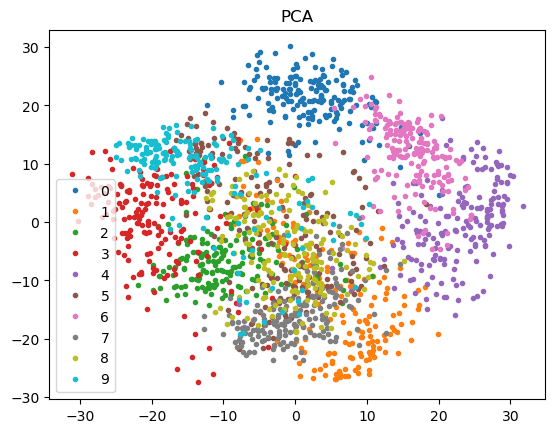

In [5]:
z_pca = PCA(n_components=d_latent).fit_transform(x)
visualize(z_pca, 'PCA')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_pca, digits.target, cv=5)
scores.mean()

0.7507180439492417

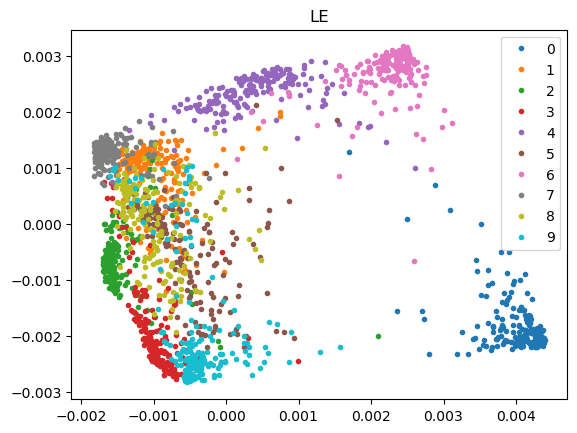

In [22]:
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
visualize(z_le, 'LE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_le, digits.target, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


0.9749705973382854

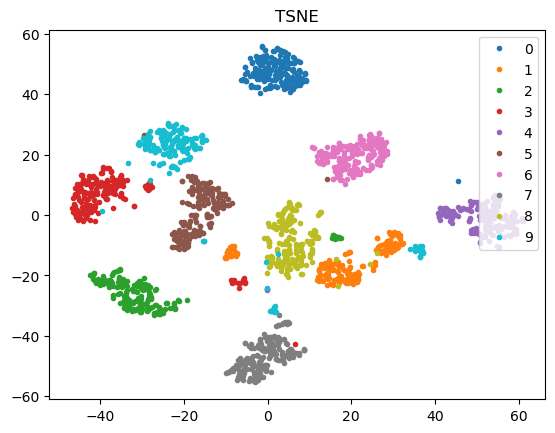

In [9]:
z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
visualize(z_tsne, 'TSNE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_tsne, digits.target, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


0.7868786753327144

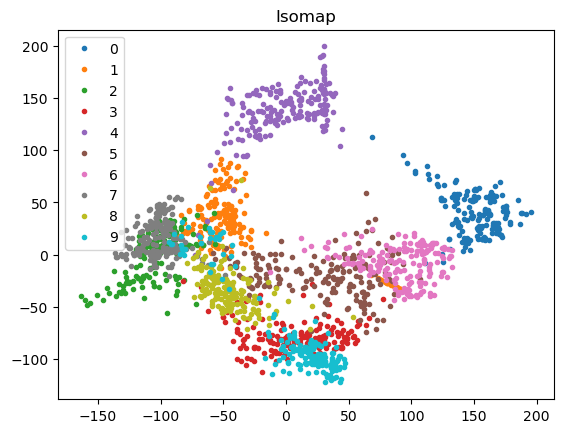

In [10]:
z_isomap = Isomap(n_components=d_latent).fit_transform(x)
visualize(z_isomap, 'Isomap')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_isomap, digits.target, cv=5)
scores.mean()

0.9755292479108636

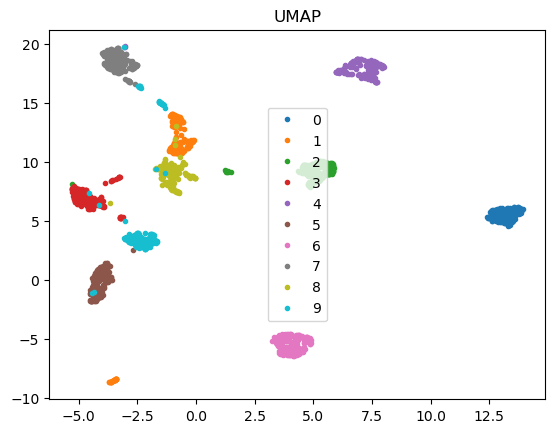

In [11]:
z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
visualize(z_umap, 'UMAP')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_umap, digits.target, cv=5)
scores.mean()

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.6, number of cliques: 232


0.5704302073661405

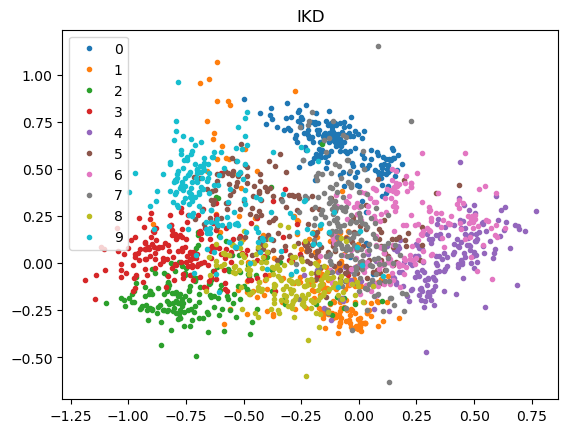

In [14]:
z_ikd = core.ikd_blockwise(x, d_latent=d_latent, clique_th=0.6, max_n_cliques=2)
visualize(z_ikd, 'IKD')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, digits.target, cv=5)
scores.mean()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   7.726302e+05           nan 
    04s44  0012   3.001751e+05   2.572039e+06 
    14s23  0039   2.603039e+05   6.062784e+06 
    41s32  0114   2.529726e+05   2.919536e+05 
 01m56s88  0324   2.521721e+05   7.404183e+04 
 05m28s95  0909   2.519403e+05   1.471947e+04 
 06m02s43  1002   2.519249e+05   2.134095e+02 
Runtime:  06m02s43
Optimization status: Maximum number of f evaluations reached



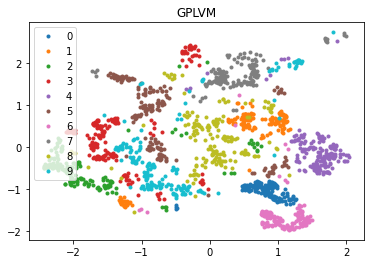

In [25]:
m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e3, messages=1)
visualize(m_gplvm.X.values, 'GPLVM')

如果已经知道距离了，那么直接取平方再取相反数，然后直接 IKD？

！！！ 本质上是更复杂的 GP 过程，生成协方差矩阵的核更复杂了

0.7690761374187559

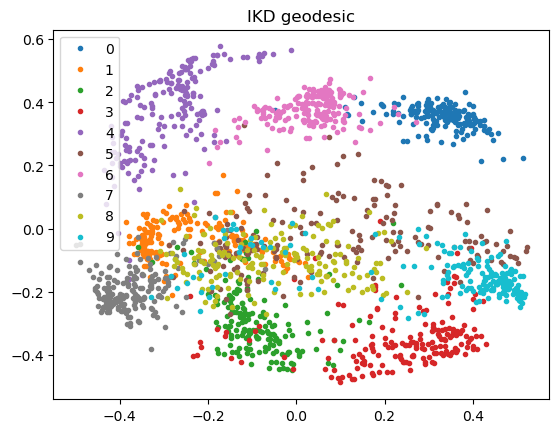

In [18]:
corr_samp = np.corrcoef(x)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= corr_samp.mean()] = 1

d = shortest_path(-np.log(corr_samp_th), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent, ref_point='center')
visualize(z_ikd, 'IKD geodesic')

clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, digits.target, cv=5)
scores.mean()

0.8758991024450633

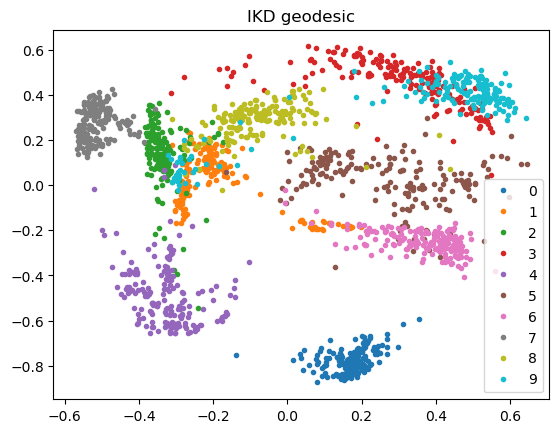

In [23]:
corr_samp = np.corrcoef(x)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= 1e-3] = 1e-3
n_points = corr_samp.shape[0]

a = -np.log(corr_samp_th)
a_new = np.zeros((n_points, n_points))
np.fill_diagonal(a, 1e5)
for i in range(n_points):
    idx = np.argpartition(a[i], 7)[:7]
    a_new[i, idx] = a[i, idx]
    a_new[idx, i] = a[idx, i]
d = shortest_path(csr_matrix(a_new), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, d_latent, ref_point='center')
visualize(z_ikd, 'IKD geodesic')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, digits.target, cv=5)
scores.mean()

## DNA

In [18]:
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"

df = pd.read_csv(URL, index_col=0)
print("Data shape: {}\n{}\n".format(df.shape, "-" * 21))
print("Data labels: {}\n{}\n".format(df.index.unique().tolist(), "-" * 86))
print("Show a small subset of the data:")
df.head()

Data shape: (437, 48)
---------------------

Data labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']
--------------------------------------------------------------------------------------

Show a small subset of the data:


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


In [19]:
x = df.values
z = df.index.values

In [20]:
def visualize(z_pred, method):
    for i in np.unique(z):
        idx = z == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

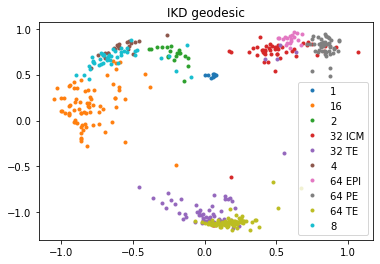

In [27]:
corr_samp = np.corrcoef(x)
corr_samp_th = corr_samp.copy()
corr_samp_th[corr_samp_th <= corr_samp.mean()] = 1

d = shortest_path(-np.log(corr_samp_th), directed=False)
corr_geodesic = np.exp(-d)

z_ikd = core.ikd(corr_geodesic, 2, ref_point='center')
visualize(z_ikd, 'IKD geodesic')

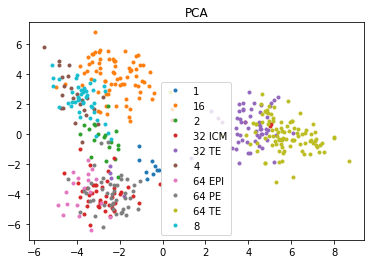

In [105]:
visualize(PCA(n_components=d_latent).fit_transform(x), 'PCA')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:324: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


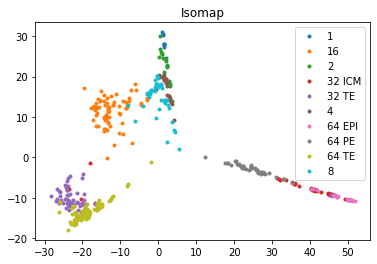

In [106]:
visualize(Isomap(n_components=d_latent).fit_transform(x), 'Isomap')

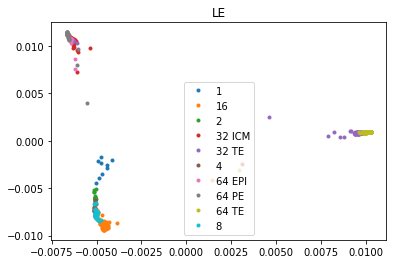

In [119]:
visualize(SpectralEmbedding(n_components=d_latent).fit_transform(x), 'LE')

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.3, number of cliques: 178


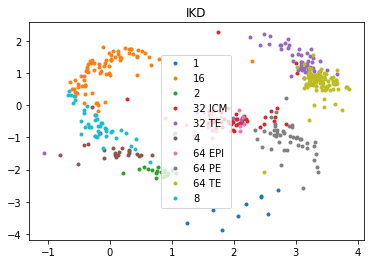

In [117]:
visualize(core.ikd_blockwise(x, d_latent=d_latent), 'IKD')